# Update IPCC AR6 ERF timeseries

- with updated **preliminary** data to 2023
- using AR6 assessments for components not directly observed

2023 update: use skew-normal rather than half-normal distributions for asymmetric uncertainty ranges.

In [1]:
import copy
import json

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats
from tqdm.auto import tqdm
from fair.forcing.ghg import meinshausen2020
import xarray as xr

In [2]:
# probablistic ensemble
SAMPLES = 100000
forcing = {}
forcing_ensemble = {}

In [3]:
NINETY_TO_ONESIGMA = scipy.stats.norm.ppf(0.95)
NINETY_TO_ONESIGMA

1.6448536269514722

In [4]:
# Required adjustment to each species to ensure overall halogenated gas ERF uncertainty is around 19%
HALOGEN_SCALING = 2.05

In [5]:
with open('../data/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [6]:
emissions = pd.read_csv('../output/slcf_emissions_1750-2023.csv', index_col=0)
emissions

,BC,OC,SO2,NOx,CO,NMVOC,NH3
1750,2.096539,15.445726,0.328965,19.416984,348.447580,60.621604,6.656572
1751,2.071691,15.186770,0.333805,19.197581,343.846182,59.690086,6.587983
1752,2.063075,15.032524,0.337382,19.200305,341.728428,59.236140,6.546281
1753,2.070710,15.180589,0.340406,19.116530,343.594444,59.632675,6.607197
1754,2.098107,15.556812,0.343722,19.264986,349.734192,60.878454,6.739907
...,...,...,...,...,...,...,...
2019,7.839246,34.732305,85.889273,142.873364,937.775808,227.214338,66.542301
2020,6.543287,28.920423,70.660488,118.263951,763.403660,189.124569,64.212985
2021,7.034582,36.432639,72.647657,123.733490,879.704910,213.313516,67.177639
2022,6.730118,25.973812,76.905100,131.847367,764.051903,189.600765,65.339760


In [7]:
concentrations = pd.read_csv('../output/ghg_concentrations_1750-2023.csv', index_col=0)
for year in range(1751, 1850):
    concentrations.loc[year, :] = np.nan
concentrations.sort_index(inplace=True)
concentrations.interpolate(inplace=True)

In [8]:
concentrations

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
YYYY,,,,,,,,,,,,,,,,,,,,,
1750,278.300,729.2000,270.100000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
1751,278.372,729.9840,270.120000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
1752,278.444,730.7680,270.140000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
1753,278.516,731.5520,270.160000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
1754,278.588,732.3360,270.180000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,410.070,1866.3275,332.091000,107.606417,32.475500,20.581125,29.596417,24.004208,7.157250,1.598292,...,0.0676,0.11836,0.096,0.40910,0.0696,0.873,1.0289,0.431520,0.0884,0.954
2020,412.440,1878.6000,333.300000,112.988500,33.728833,23.658333,32.783417,25.557917,7.092792,1.750542,...,0.0690,0.11984,0.097,0.40725,0.0704,0.920,1.0262,0.450585,0.0884,0.938
2021,414.700,1896.0000,334.600000,118.727000,34.894017,28.450000,36.728500,27.502500,7.392250,1.966083,...,0.0704,0.12132,0.098,0.40540,0.0712,0.967,1.0235,0.458490,0.0884,0.922


In [9]:
# uncertainties from IPCC
uncertainty_seed = 38572

unc_ranges = {
    'CO2':          0.12/NINETY_TO_ONESIGMA,
    'CH4':          0.20/NINETY_TO_ONESIGMA,
    'N2O':          0.14/NINETY_TO_ONESIGMA,
    'HFC-125':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-134a':     0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-143a':     0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-152a':     0.26/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-227ea':    0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-23':       0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-236fa':    0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-245fa':    0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-32':       0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-365mfc':   0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HFC-43-10mee': 0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'NF3':          0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'C2F6':         0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'C3F8':         0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'n-C4F10':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'n-C5F12':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'n-C6F14':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'i-C6F14':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'C7F16':        0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'C8F18':        0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CF4':          0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'c-C4F8':       0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'SF6':          0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'SO2F2':        0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CCl4':         0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-11':       0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-112':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-112a':     0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-113':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-113a':     0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-114':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-114a':     0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-115':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-12':       0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CFC-13':       0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CH2Cl2':       0.26/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CH3Br':        0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CH3CCl3':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CH3Cl':        0.26/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'CHCl3':        0.26/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HCFC-124':     0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HCFC-133a':    0.26/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HCFC-141b':    0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HCFC-142b':    0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HCFC-22':      0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'HCFC-31':      0.26/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'Halon-1211':   0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'Halon-1301':   0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'Halon-2402':   0.19/NINETY_TO_ONESIGMA*HALOGEN_SCALING,
    'O3':           0.50/NINETY_TO_ONESIGMA,      # Total ozone
    'H2O_stratospheric': 1.00/NINETY_TO_ONESIGMA,      # stratospheric WV from CH4
    'contrails':    0.70/NINETY_TO_ONESIGMA,      # contrails approx - half-normal
    'BC_on_snow':   1.25/NINETY_TO_ONESIGMA,      # bc on snow - half-normal
    'land_use':     0.50/NINETY_TO_ONESIGMA,      # land use change
    'volcanic':     0.25/NINETY_TO_ONESIGMA,  # volcanic
    'solar': 0.5/NINETY_TO_ONESIGMA,      # solar (amplitude)
}

In [10]:
scale_df = pd.DataFrame(
    scipy.stats.norm.rvs(
        size=(SAMPLES, 59), 
        loc=np.ones((SAMPLES, 59)), 
        scale=pd.Series(unc_ranges), 
        random_state=uncertainty_seed
    ), columns=unc_ranges.keys()
)

In [11]:
def opt(x, q05_desired, q50_desired, q95_desired):
    "x is (a, loc, scale) in that order."
    q05, q50, q95 = scipy.stats.skewnorm.ppf(
        (0.05, 0.50, 0.95), x[0], loc=x[1], scale=x[2]
    )
    return (q05 - q05_desired, q50 - q50_desired, q95 - q95_desired)

In [12]:
lapsi_params = scipy.optimize.root(opt, [1, 1, 1], args=(0, 1, 2.25)).x
contrails_params = scipy.optimize.root(opt, [1, 1, 1], args=(19 / 57, 1, 98 / 57)).x

In [13]:
## skewnormal for asymmetric distributions
scale_df['BC_on_snow'] = scipy.stats.skewnorm.rvs(
    lapsi_params[0],
    loc=lapsi_params[1],
    scale=lapsi_params[2],
    size=SAMPLES,
    random_state=3701584,
)

scale_df['contrails'] = scipy.stats.skewnorm.rvs(
    contrails_params[0],
    loc=contrails_params[1],
    scale=contrails_params[2],
    size=SAMPLES,
    random_state=3701585,
)

trend_solar = scipy.stats.norm.rvs(
    size=SAMPLES, 
    loc=0.00, 
    scale=0.07/NINETY_TO_ONESIGMA, 
    random_state=uncertainty_seed
)

In [14]:
scale_df

,CO2,CH4,N2O,HFC-125,HFC-134a,HFC-143a,HFC-152a,HFC-227ea,HFC-23,HFC-236fa,...,Halon-1211,Halon-1301,Halon-2402,O3,H2O_stratospheric,contrails,BC_on_snow,land_use,volcanic,solar
0,0.943261,0.978187,1.025718,0.972672,0.906087,0.945999,0.634211,1.361942,0.826497,1.063753,...,0.927218,1.303551,0.997593,0.787303,0.042383,0.591381,2.034792,1.157831,0.825456,0.919646
1,1.081689,0.889672,0.913186,0.777043,1.059723,0.939268,1.121865,1.120371,1.040670,0.557967,...,1.022598,0.868671,1.199254,0.793472,0.744995,1.143134,0.779814,0.785643,1.258619,0.904002
2,1.009974,1.243387,0.986998,1.022708,1.036060,1.337380,1.214269,1.184328,1.059761,0.867828,...,1.020137,1.075843,1.260783,1.154118,0.612477,0.853633,1.859592,1.453946,0.988822,1.424369
3,1.011393,0.960568,1.131976,1.280258,0.700198,1.465061,1.864686,0.566297,0.750100,1.224274,...,1.132601,0.925923,0.568066,0.974274,0.156442,0.781731,0.819484,1.214584,0.787854,1.077480
4,1.011724,1.057738,0.983756,0.896104,1.108065,0.975647,1.529809,0.729508,0.979181,0.782847,...,1.084588,0.802954,1.148949,0.952455,1.269201,0.900270,2.106909,0.968993,1.216154,0.329418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.913626,0.927868,0.936317,0.908699,1.125302,1.214820,0.926806,1.257996,0.812820,1.180854,...,0.981350,1.205797,0.868995,0.680882,0.861461,1.273597,0.989189,0.837155,0.669461,0.655185
99996,1.044751,0.938671,1.105289,0.847806,0.924521,1.225607,1.156050,1.007165,1.318353,0.638329,...,1.215462,1.153130,0.851433,0.718387,0.840706,0.987066,0.714938,0.843591,0.826582,1.292599
99997,0.964884,1.057394,1.012689,0.546273,0.943393,0.982263,1.454491,1.255695,1.206037,1.239768,...,1.155062,1.129631,0.980740,1.409114,0.011992,1.707830,-0.029660,0.924978,1.000796,1.046371
99998,1.018512,0.933249,0.941076,0.955143,1.061930,1.083401,1.587492,1.026183,1.215810,1.316523,...,1.242252,0.690557,0.580869,0.901715,1.826166,0.751064,0.600850,0.942392,1.341195,1.136525


### Solar radiation

No change from AR6 - yet - so not re-generated here - using the data provided as-is.

net change in TOA radiation = delta TSI * 1/4 * 0.71 * 0.72 where 1/4 is geometric factor, 0.71 is planetary co-albedo, 0.72 is rapid adjustment factor. Pre-industrial is defined as the mean TSI for complete solar cycles from 6755 BCE to 1750 CE.

On top of this we add a linear trend from 1750 to 2019 based on the PD uncertainty assessment of +/- 0.07.

In [15]:
df_solar = pd.read_csv('../data/ar6/solar_erf.csv', index_col=0)
forcing['solar'] = df_solar.loc[1750:2023].values.squeeze()

In [16]:
df_solar.loc[2019:2023]

,solar_erf
year,
2019,-0.022173
2020,-0.016969
2021,0.019557
2022,0.059393
2023,0.081982


In [17]:
df_solar.loc[2009:2019].mean()  # cycle 24 was Dec 2008 to Dec 2019: https://en.wikipedia.org/wiki/Solar_cycle_24

solar_erf    0.008964
dtype: float64

In [18]:
# as AR6, trend extended to 2023, but with 2019 end
trend = np.ones(274)
trend[:270] = np.linspace(0, 1, 270)

In [19]:
forcing_ensemble['solar'] = trend[:,None] * trend_solar[None,:] + forcing['solar'][:,None] * scale_df['solar'].values[None,:]

### Volcanic forcing

Calculated separately in the `volcanic-forcing` notebook.

In [20]:
df_volcanic = pd.read_csv('../output/volcanic_sAOD_ERF_annual_-9500-2023.csv', index_col=0)
forcing['volcanic'] = df_volcanic.loc[1750.5:2023.5, 'volcanic_ERF'].values.squeeze()

### Aerosol forcing

In AR6, ERFari was based on emissions to forcing coefficients from Myhre et al (2013) https://acp.copernicus.org/articles/13/1853/2013/. At the time, I deemed there not sufficient evidence from CMIP6 AerChemMIP models or any other sources to update these. The uncertainty ranges from each precursor were expanded slightly compared to Myhre et al., in order to reproduce the overall ERFari uncertainty assessment (assumed that uncertainties in individual components are uncorrelated).

Following AR6 and a re-calibration of FaIR, I now use Bill Collins/Terje Bertnsen/Sara Blichner/Sophie Szopa's chapter 6 correspondences of emissions or concentrations to forcing.

ERFaci is based on fits to CMIP6 models from Smith et al. (2021) now updated to include 13 models and correct APRP code from Mark Zelinka.

Rescale both to the assessed forcings of -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

In [21]:
# these come from AR6 WG1
# source: https://github.com/sarambl/AR6_CH6_RCMIPFIGS/blob/master/ar6_ch6_rcmipfigs/data_out/fig6_12_ts15_historic_delta_GSAT/2019_ERF_est.csv
# they sum to -0.22 W/m2, for 2019
# Calculate a radiative efficiency for each species from CEDS and updated concentrations.
df_ari_emitted_mean = pd.read_csv('../data/ar6/table_mean_thornhill_collins_orignames.csv', index_col=0)
erfari_emitted = pd.Series(df_ari_emitted_mean['Aerosol'])
erfari_emitted.rename_axis(None, inplace=True)
erfari_emitted.rename({'HC': 'EESC', 'VOC': 'NMVOC'}, inplace=True)
erfari_emitted

CO2      0.000000
CH4     -0.002653
N2O     -0.002090
EESC    -0.008080
NOx     -0.009166
NMVOC   -0.002573
SO2     -0.234228
OC      -0.072143
BC       0.144702
NH3     -0.033769
Name: Aerosol, dtype: float64

In [22]:
df_ari_emitted_std = pd.read_csv('../data/ar6/table_std_thornhill_collins_orignames.csv', index_col=0)
erfari_emitted_std = pd.Series(df_ari_emitted_std['Aerosol_sd'])
erfari_emitted_std.rename_axis(None, inplace=True)
erfari_emitted_std.rename({'HC': 'EESC', 'VOC': 'NMVOC'}, inplace=True)
erfari_emitted_std

CO2      0.000000
CH4      0.002197
N2O      0.002021
EESC     0.001971
NOx      0.004543
NMVOC    0.005065
SO2      0.223907
OC       0.065461
BC       0.158984
NH3      0.004824
Name: Aerosol_sd, dtype: float64

In [23]:
def calculate_eesc(
    concentration,
    fractional_release,
    fractional_release_cfc11,
    cl_atoms,
    br_atoms,
    br_cl_ratio=45,
):

    # EESC is in terms of CFC11-eq
    eesc_out = (
        cl_atoms * (concentration) * fractional_release / fractional_release_cfc11
        + br_cl_ratio
        * br_atoms
        * (concentration)
        * fractional_release
        / fractional_release_cfc11
    ) * fractional_release_cfc11
    return eesc_out


fractional_release = {
    "CFC-11": 0.47,
    "CFC-12": 0.23,
    "CFC-113": 0.29,
    "CFC-114": 0.12,
    "CFC-115": 0.04,
    "HCFC-22": 0.13,
    "HCFC-141b": 0.34,
    "HCFC-142b": 0.17,
    "CCl4": 0.56,
    "CHCl3": 0,
    "CH2Cl2": 0,
    "CH3Cl": 0.44,
    "CH3CCl3": 0.67,
    "CH3Br": 0.6,
    "Halon-1211": 0.62,
    "Halon-1301": 0.28,
    "Halon-2402": 0.65,
}

cl_atoms = {
    "CFC-11": 3,
    "CFC-12": 2,
    "CFC-113": 3,
    "CFC-114": 2,
    "CFC-115": 1,
    "HCFC-22": 1,
    "HCFC-141b": 2,
    "HCFC-142b": 1,
    "CCl4": 4,
    "CHCl3": 3,
    "CH2Cl2": 2,
    "CH3Cl": 1,
    "CH3CCl3": 3,
    "CH3Br": 0,
    "Halon-1211": 1,
    "Halon-1301": 0,
    "Halon-2402": 0,
}

br_atoms = {
    "CFC-11": 0,
    "CFC-12": 0,
    "CFC-113": 0,
    "CFC-114": 0,
    "CFC-115": 0,
    "HCFC-22": 0,
    "HCFC-141b": 0,
    "HCFC-142b": 0,
    "CCl4": 0,
    "CHCl3": 0,
    "CH2Cl2": 0,
    "CH3Cl": 0,
    "CH3CCl3": 0,
    "CH3Br": 1,
    "Halon-1211": 1,
    "Halon-1301": 1,
    "Halon-2402": 2,
}

hc_eesc = {}
total_eesc = np.zeros(274)
for species in cl_atoms:
    hc_eesc[species] = calculate_eesc(
        concentrations.loc[:, species],
        fractional_release[species],
        fractional_release["CFC-11"],
        cl_atoms[species],
        br_atoms[species],
    )
    total_eesc = total_eesc + hc_eesc[species]

total_eesc

YYYY
1750     344.362758
1751     344.362758
1752     344.362758
1753     344.362758
1754     344.362758
           ...     
2019    1417.259803
2020    1409.018742
2021    1394.112692
2022    1381.622330
2023    1368.639247
Length: 274, dtype: float64

In [24]:
#total_eesc = total_eesc.to_frame('EESC')

In [25]:
# erfari radiative efficiency per Mt or ppb or ppt
re = erfari_emitted / (emissions.loc[2019, :] - emissions.loc[1750, :])
re.dropna(inplace=True)

In [26]:
re['CH4'] = erfari_emitted['CH4'] / (concentrations.loc[2019, 'CH4'] - concentrations.loc[1750, 'CH4'])
re['N2O'] = erfari_emitted['N2O'] / (concentrations.loc[2019, 'N2O'] - concentrations.loc[1750, 'N2O'])
re['EESC'] = erfari_emitted['EESC'] / (total_eesc.loc[2019] - total_eesc.loc[1750])

In [27]:
re

BC       0.025198
NH3     -0.000564
NMVOC   -0.000015
NOx     -0.000074
OC      -0.003741
SO2     -0.002738
CH4     -0.000002
N2O     -0.000034
EESC    -0.000008
dtype: float64

In [28]:
re_std = erfari_emitted_std / (emissions.loc[2019, :] - emissions.loc[1750, :])
re_std.dropna(inplace=True)
re_std['CH4'] = erfari_emitted_std['CH4'] / (concentrations.loc[2019, 'CH4'] - concentrations.loc[1750, 'CH4'])
re_std['N2O'] = erfari_emitted_std['N2O'] / (concentrations.loc[2019, 'N2O'] - concentrations.loc[1750, 'N2O'])
re_std['EESC'] = erfari_emitted_std['EESC'] / (total_eesc.loc[2019] - total_eesc.loc[1750])
re_std

BC       0.027684
NH3      0.000081
NMVOC    0.000030
NOx      0.000037
OC       0.003394
SO2      0.002617
CH4      0.000002
N2O      0.000033
EESC     0.000002
dtype: float64

In [29]:
re.index

Index(['BC', 'NH3', 'NMVOC', 'NOx', 'OC', 'SO2', 'CH4', 'N2O', 'EESC'], dtype='object')

In [30]:
erfari_best = pd.concat(
    (
        (re * emissions)[['BC', 'OC', 'SO2', 'NOx', 'NMVOC', 'NH3']] - (re * emissions.loc[1750, ['BC', 'OC', 'SO2', 'NOx', 'NMVOC', 'NH3']]),
        (re * concentrations)[['CH4', 'N2O']] - (re * concentrations.loc[1750, ['CH4', 'N2O']]),
        re['EESC'] * (total_eesc - total_eesc.loc[1750])
    ), axis=1
).dropna(axis=1).sum(axis=1)

In [31]:
# 90% range of ERF uncertainty in 2019 from model estimates
np.sqrt((erfari_emitted_std**2).sum()) * NINETY_TO_ONESIGMA

0.4645881114431425

In [32]:
# 90% range of ERF uncertainty in 2005-2014 from model estimates
(erfari_best.loc[2005:2014].mean()/-0.22) * np.sqrt((erfari_emitted_std**2).sum()) * NINETY_TO_ONESIGMA

0.5697428456545748

In [33]:
# best estimate ERF in 2005-2014 from model estimates
erfari_best.loc[2005:2014].mean()

-0.2697947342101678

In [34]:
# we need to map the -0.27 +/- 0.57 to -0.3 +/- 0.3 which is the IPCC AR6 assessment
best_scale = -0.3 / erfari_best.loc[2005:2014].mean()
unc_scale = 0.3 / ((erfari_best.loc[2005:2014].mean()/-0.22) * np.sqrt((erfari_emitted_std**2).sum()) * NINETY_TO_ONESIGMA)

In [35]:
best_scale, unc_scale

(1.1119564689735661, 0.5265533429477846)

In [36]:
forcing['aerosol-radiation_interactions'] = (erfari_best * best_scale).values

In [37]:
for specie in ['BC', 'OC', 'SO2', 'NOx', 'NMVOC', 'NH3']:
    print(specie, (emissions.loc[2023, specie] - emissions.loc[1750, specie]) * re[specie])


BC 0.13987645626851325
OC -0.09640595013759704
SO2 -0.21995805976849986
NOx -0.0089938263752047
NMVOC -0.0027345429832642872
NH3 -0.035742122199108106


In [38]:
# convert to numpy for efficiency
erfari_re_samples = pd.DataFrame(
    scipy.stats.norm.rvs(
        re*best_scale, re_std*unc_scale, size=(SAMPLES, 9), random_state=3729329,
    ),
    columns = re.index
)[['BC', 'OC', 'SO2', 'NOx', 'NMVOC', 'NH3', 'CH4', 'N2O', 'EESC']]

In [39]:
erfari_re_samples

,BC,OC,SO2,NOx,NMVOC,NH3,CH4,N2O,EESC
0,0.041992,-0.001922,-0.003362,-0.000083,-0.000033,-0.000675,-0.000002,-0.000019,-0.000010
1,0.032042,-0.007175,-0.001950,-0.000059,0.000005,-0.000574,-0.000002,0.000005,-0.000009
2,0.018397,-0.005332,-0.000930,-0.000070,-0.000009,-0.000716,-0.000003,-0.000007,-0.000009
3,0.016488,-0.004835,-0.002080,-0.000066,-0.000029,-0.000620,-0.000003,-0.000024,-0.000008
4,0.033823,-0.003739,-0.003481,-0.000081,-0.000046,-0.000559,-0.000001,-0.000034,-0.000009
...,...,...,...,...,...,...,...,...,...
99995,0.042760,-0.002173,-0.003173,-0.000060,-0.000034,-0.000647,-0.000003,-0.000051,-0.000009
99996,0.047021,-0.003453,-0.001065,-0.000078,0.000018,-0.000602,-0.000002,-0.000031,-0.000007
99997,0.031063,-0.004670,-0.001977,-0.000059,-0.000004,-0.000584,-0.000003,-0.000043,-0.000009
99998,0.040787,-0.003672,-0.004020,-0.000073,0.000029,-0.000609,-0.000004,-0.000038,-0.000009


In [40]:
erfari_re_samples = erfari_re_samples.to_numpy()

In [41]:
# a future TODO is to split CO out from the NMVOC estimate
emnump = emissions.drop(columns=['CO']).to_numpy()

In [42]:
forcing_ensemble['aerosol-radiation_interactions'] = np.zeros((274, SAMPLES))
for i in tqdm(range(SAMPLES)):
    forcing_ensemble['aerosol-radiation_interactions'][:, i] = (
        (
            ((erfari_re_samples[i, :6] * emnump) - (erfari_re_samples[i, :6] * emnump[0, :])).sum(axis=1) + 
            ((erfari_re_samples[i, 6] * concentrations['CH4'].values) - (erfari_re_samples[i, 6] * concentrations.loc[1750, 'CH4'])) +
            ((erfari_re_samples[i, 7] * concentrations['N2O'].values) - (erfari_re_samples[i, 7] * concentrations.loc[1750, 'N2O'])) +
            (erfari_re_samples[i, 8] * (total_eesc.values - total_eesc.loc[1750]))
        )
    )

  0%|          | 0/100000 [00:00<?, ?it/s]

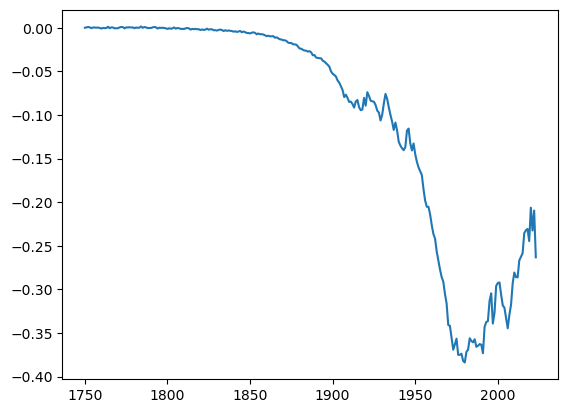

In [43]:
pl.plot(erfari_best * best_scale)

In [44]:
np.percentile(forcing_ensemble['aerosol-radiation_interactions'][255:265, :].mean(axis=0), (5, 50, 95))

array([-0.59557417, -0.2998534 , -0.00253067])

In [45]:
df_aci_cal = pd.read_csv('../data/fair-calibrate-1.4.1/aerosol_cloud.csv', index_col=0)

In [46]:
df_aci_cal

,aci_scale,Sulfur,BC,OC
E3SM-2-0,-1.443485,7.152779e-02,3.762593e-41,3.518178e-01
HadGEM3-GC31-LL,-0.940580,2.222328e-02,5.954012e-33,3.674180e-02
GFDL-ESM4,-13197.573317,2.544719e-07,2.699782e-06,6.070785e-07
CNRM-CM6-1,-1.496729,6.005013e-03,4.602495e-02,1.113794e-02
CanESM5,-0.856032,1.992724e-02,3.940789e-01,1.281973e-16
NorESM2-LM,-12953.242881,6.681038e-07,2.927736e-89,1.569533e-06
MRI-ESM2-0,-7.743980,7.756472e-04,4.118827e-03,5.907474e-27
MIROC6,-1.025414,7.298451e-03,1.485128e-01,6.270682e-18
IPSL-CM6A-LR,-1.262191,2.660200e-03,2.010784e-16,1.897347e-03
GISS-E2-1-G,-0.584806,8.194178e-03,1.283971e+00,2.548500e-11


In [47]:
beta_samp = df_aci_cal["aci_scale"]
n0_samp = df_aci_cal["Sulfur"]
n1_samp = df_aci_cal["BC"]
n2_samp = df_aci_cal["OC"]

In [48]:
np.log(n0_samp)

E3SM-2-0           -2.637669
HadGEM3-GC31-LL    -3.806615
GFDL-ESM4         -15.184075
CNRM-CM6-1         -5.115161
CanESM5            -3.915668
NorESM2-LM        -14.218822
MRI-ESM2-0         -7.161813
MIROC6             -4.920093
IPSL-CM6A-LR       -5.929354
GISS-E2-1-G        -4.804331
GFDL-CM4          -13.721276
MPI-ESM-1-2-HAM    -4.936328
UKESM1-0-LL        -3.397134
Name: Sulfur, dtype: float64

In [49]:
np.log(n1_samp)

E3SM-2-0           -93.080880
HadGEM3-GC31-LL    -74.201243
GFDL-ESM4          -12.822340
CNRM-CM6-1          -3.078572
CanESM5             -0.931204
NorESM2-LM        -203.855844
MRI-ESM2-0          -5.492187
MIROC6              -1.907084
IPSL-CM6A-LR       -36.142837
GISS-E2-1-G          0.249957
GFDL-CM4           -14.339126
MPI-ESM-1-2-HAM    -28.234287
UKESM1-0-LL        -83.076751
Name: BC, dtype: float64

In [50]:
np.log(n2_samp)

E3SM-2-0           -1.044642
HadGEM3-GC31-LL    -3.303840
GFDL-ESM4         -14.314608
CNRM-CM6-1         -4.497398
CanESM5           -36.592961
NorESM2-LM        -13.364732
MRI-ESM2-0        -60.393579
MIROC6            -39.610647
IPSL-CM6A-LR       -6.267299
GISS-E2-1-G       -24.392931
GFDL-CM4          -13.064300
MPI-ESM-1-2-HAM    -4.630382
UKESM1-0-LL       -28.069171
Name: OC, dtype: float64

In [51]:
kde = scipy.stats.gaussian_kde([np.log(n0_samp), np.log(n1_samp), np.log(n2_samp)], bw_method=0.1)
aci_sample = kde.resample(size=SAMPLES * 1, seed=63648708)

In [52]:
#aci_sample[0, aci_sample[0, :] > 0] = 0#np.nan
#aci_sample[1, aci_sample[1, :] > 0] = 0#np.nan
#aci_sample[2, aci_sample[2, :] > 0] = 0#np.nan
# mask = np.any(np.isnan(aci_sample), axis=0)
# aci_sample = aci_sample[:, ~mask]

In [53]:
erfaci_sample = scipy.stats.norm.rvs(
    size=SAMPLES, loc=-1.0, scale=0.7/NINETY_TO_ONESIGMA, random_state=71271
)

In [54]:
so2 = emissions['SO2'].values
bc = emissions['BC'].values
oc = emissions['OC'].values

In [55]:
beta = np.zeros(SAMPLES)

In [56]:
def aci_log(x, beta, n0, n1, n2):
    aci = beta * np.log(1 + x[0] * n0 + x[1] * n1 + x[2] * n2)
    return aci

In [57]:
forcing_ensemble['aerosol-cloud_interactions'] = np.zeros((274, SAMPLES))
for i in tqdm(range(SAMPLES), desc="aci samples"):
    ts2010 = np.mean(
        aci_log(
            [so2[255:265], bc[255:265], oc[255:265]],
            1.1,
            np.exp(aci_sample[0, i]),
            np.exp(aci_sample[1, i]),
            np.exp(aci_sample[2, i]),
        )
    )
    ts1750 = aci_log(
        [so2[0], bc[0], oc[0]],
        1.1,
        np.exp(aci_sample[0, i]),
        np.exp(aci_sample[1, i]),
        np.exp(aci_sample[2, i]),
    )
    forcing_ensemble['aerosol-cloud_interactions'][:, i] = (
       (
           aci_log(
               [so2, bc, oc],
               1.1,
               np.exp(aci_sample[0, i]),
               np.exp(aci_sample[1, i]),
               np.exp(aci_sample[2, i]),
           )
           - ts1750
       )
       / (ts2010 - ts1750)
       * (erfaci_sample[i])
    )
    beta[i] = erfaci_sample[i] / (ts2010 - ts1750)

aci samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [58]:
#pl.plot(erfaci);
#pl.ylim(-6, 0.2)

In [59]:
(forcing_ensemble['aerosol-cloud_interactions'][255:265, :]).mean()

-1.0017119789332796

In [60]:
np.median(forcing_ensemble['aerosol-cloud_interactions'][255:265, :].mean(axis=0))

-0.9994433263455187

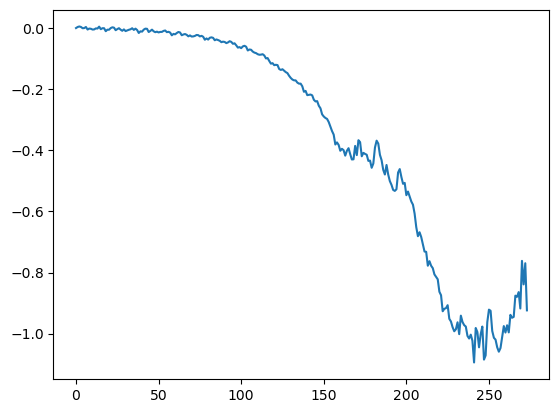

In [61]:
forcing['aerosol-cloud_interactions'] = np.median(forcing_ensemble['aerosol-cloud_interactions'], axis=1)
pl.plot(forcing['aerosol-cloud_interactions'])

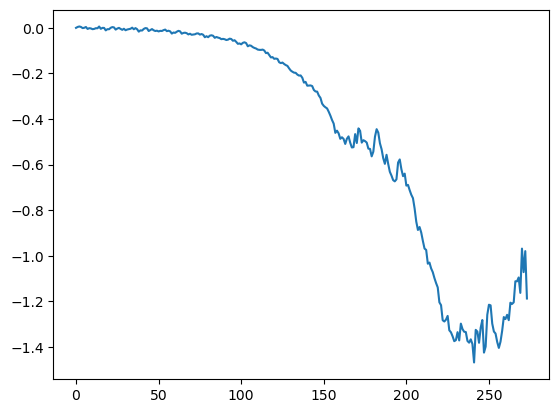

In [62]:
pl.plot(forcing['aerosol-radiation_interactions'] + forcing['aerosol-cloud_interactions'])

### Contrail forcing

Update for 2023: calculated in `contrails.ipynb`

In [63]:
df_contrails = pd.read_csv('../output/contrails_ERF_1930-2023.csv', index_col=0)
forcing['contrails'] = np.zeros(274)
forcing['contrails'][180:] = df_contrails.values.squeeze()

### Land use forcing

Use cumulative land use CO2 emissions, scale to -0.2 W/m2 for 1750 to 2019. Demonstrate this is fairly close to an observational estimate (Ghimire et al. 2015)

In [64]:
df_gcp = pd.read_csv('../data/gcp_emissions/gcp_2023.csv', index_col=0)

In [65]:
df_gcp['AFOLU']

year
1750    0.003000
1751    0.009000
1752    0.015000
1753    0.021000
1754    0.027000
          ...   
2019    1.254780
2020    1.172267
2021    1.179470
2022    1.176297
2023    1.100000
Name: AFOLU, Length: 274, dtype: float64

In [66]:
lusf2019 = -0.20/(np.cumsum(df_gcp['AFOLU']).loc[2019] - df_gcp.loc[1750, 'AFOLU'])
lusf2019

-0.00081514382900391

In [67]:
forcing['land_use'] = (np.cumsum(df_gcp['AFOLU']) - df_gcp.loc[1750, 'AFOLU']).values*lusf2019

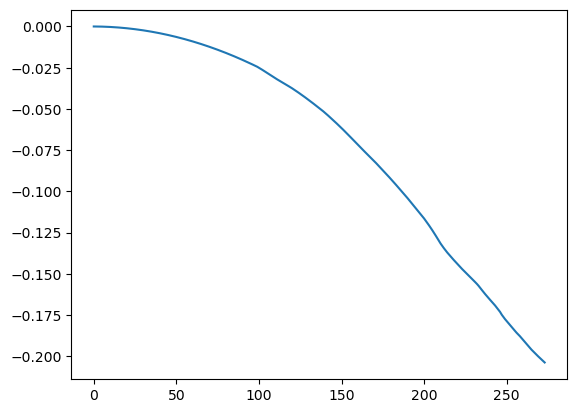

In [68]:
pl.plot(forcing['land_use'])

## BC on snow

linear with emissions, 2019 ERF = 0.08

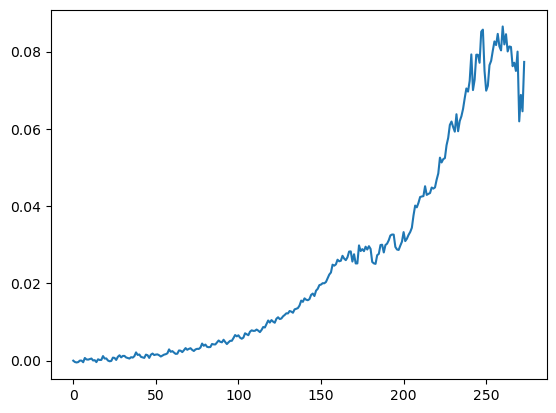

In [69]:
emissions.loc[2019,'BC']
forcing['BC_on_snow'] = (0.08*(emissions['BC']-emissions.loc[1750,'BC'])/(emissions.loc[2019,'BC']-emissions.loc[1750,'BC'])).values.squeeze()
pl.plot(forcing['BC_on_snow'])

### Greenhouse gas concentrations

Here, tropospheric and surface adjustments are only implemented for CO2, CH4, N2O, CFC11 and CFC12 to convert SARF to ERF. There's an argument to uplift ERF by 5% for other GHGs based on land surface warming, but the total forcing will be very small and no single-forcing studies exist. This was not done in AR6 chapter 7.

Radiative efficiencies for F-gases are from Hodnebrog et al. 2020 https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019RG000691.

In [70]:
concentrations

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
YYYY,,,,,,,,,,,,,,,,,,,,,
1750,278.300,729.2000,270.100000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
1751,278.372,729.9840,270.120000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
1752,278.444,730.7680,270.140000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
1753,278.516,731.5520,270.160000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
1754,278.588,732.3360,270.180000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,0.000004,...,0.0000,0.00000,0.000,0.00000,0.0000,0.000,0.0000,0.000000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,410.070,1866.3275,332.091000,107.606417,32.475500,20.581125,29.596417,24.004208,7.157250,1.598292,...,0.0676,0.11836,0.096,0.40910,0.0696,0.873,1.0289,0.431520,0.0884,0.954
2020,412.440,1878.6000,333.300000,112.988500,33.728833,23.658333,32.783417,25.557917,7.092792,1.750542,...,0.0690,0.11984,0.097,0.40725,0.0704,0.920,1.0262,0.450585,0.0884,0.938
2021,414.700,1896.0000,334.600000,118.727000,34.894017,28.450000,36.728500,27.502500,7.392250,1.966083,...,0.0704,0.12132,0.098,0.40540,0.0712,0.967,1.0235,0.458490,0.0884,0.922


In [71]:
meinshausen2020

<function fair.forcing.ghg.meinshausen2020(concentration, reference_concentration, forcing_scaling, radiative_efficiency, co2_indices, ch4_indices, n2o_indices, minor_greenhouse_gas_indices, a1=-2.4785e-07, b1=0.00075906, c1=-0.0021492, d1=5.2488, a2=-0.00034197, b2=0.00025455, c2=-0.00024357, d2=0.12173, a3=-8.9603e-05, b3=-0.00012462, d3=0.045194)>

In [72]:
concentrations.loc[2023].values.shape

(52,)

In [73]:
# radiative efficiencies
# source: Hodnebrog et al 2020 https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019RG000691
radeff = {
    'HFC-125':      0.23378,
    'HFC-134a':     0.16714,
    'HFC-143a':     0.168,
    'HFC-152a':     0.10174,
    'HFC-227ea':    0.27325,
    'HFC-23':       0.19111,
    'HFC-236fa':    0.25069,
    'HFC-245fa':    0.24498,
    'HFC-32':       0.11144,
    'HFC-365mfc':   0.22813,
    'HFC-43-10mee': 0.35731,
    'NF3':          0.20448,
    'C2F6':         0.26105,
    'C3F8':         0.26999,
    'n-C4F10':      0.36874,
    'n-C5F12':      0.4076,
    'n-C6F14':      0.44888,
    'i-C6F14':      0.44888,
    'C7F16':        0.50312,
    'C8F18':        0.55787,
    'CF4':          0.09859,
    'c-C4F8':       0.31392,
    'SF6':          0.56657,
    'SO2F2':        0.21074,
    'CCl4':         0.16616,
    'CFC-11':       0.25941,
    'CFC-112':      0.28192,
    'CFC-112a':     0.24564,
    'CFC-113':      0.30142,
    'CFC-113a':     0.24094, 
    'CFC-114':      0.31433,
    'CFC-114a':     0.29747,
    'CFC-115':      0.24625,
    'CFC-12':       0.31998,
    'CFC-13':       0.27752,
    'CH2Cl2':       0.02882,
    'CH3Br':        0.00432,
    'CH3CCl3':      0.06454,
    'CH3Cl':        0.00466,
    'CHCl3':        0.07357,
    'HCFC-124':     0.20721,
    'HCFC-133a':    0.14995,
    'HCFC-141b':    0.16065,
    'HCFC-142b':    0.19329,
    'HCFC-22':      0.21385,
    'HCFC-31':      0.068,
    'Halon-1202':   0,       # not in dataset
    'Halon-1211':   0.30014,
    'Halon-1301':   0.29943,
    'Halon-2402':   0.31169,
    'CO2':          0,       # different relationship
    'CH4':          0,       # different relationship
    'N2O':          0        # different relationship
}

radeff_array = np.ones(52) * np.nan
for igas, gas in enumerate(concentrations.columns):
    radeff_array[igas] = radeff[gas]

In [74]:
np.where(concentrations.columns=='CFC-11')[0][0], np.where(concentrations.columns=='CFC-12')[0][0]

(22, 21)

In [75]:
adjustments = np.ones(52)
adjustments[0] = 1.05
adjustments[1] = 0.86
adjustments[2] = 1.07
adjustments[21] = 1.12
adjustments[22] = 1.13

In [76]:
meinshausen2020(
    concentrations.loc[2019].values,
    concentrations.loc[1750].values,
    adjustments,
    radeff_array,
    [0],
    [1],
    [2],
    list(range(3,52))
)

array([2.15932937e+00, 5.43982988e-01, 2.08459079e-01, 1.79853365e-02,
       6.20639280e-03, 2.29353623e-03, 6.91905029e-03, 4.03270700e-03,
       7.28178615e-04, 4.36732118e-04, 4.91561308e-05, 7.58641815e-04,
       2.46893692e-04, 1.03232814e-04, 4.24756080e-04, 5.63397208e-03,
       5.26880697e-04, 5.07823945e-03, 1.26548305e-03, 1.84830654e-04,
       5.49360000e-04, 1.80247866e-01, 6.63127617e-02, 2.10388146e-02,
       5.12203354e-03, 2.13685490e-03, 9.10011207e-04, 5.27698042e-02,
       3.91684112e-03, 4.29495212e-03, 1.05135660e-04, 1.29695564e-02,
       3.90593822e-04, 5.14602943e-06, 8.60630045e-04, 2.92918955e-04,
       9.77196841e-04, 9.93670931e-04, 1.24247426e-04, 7.49279664e-05,
       6.08139200e-05, 1.03062846e-04, 3.03442880e-05, 5.95492810e-05,
       5.35555200e-05, 1.15333471e-04, 1.70965448e-05, 2.10340619e-04,
       3.06066886e-04, 6.47064240e-05, 6.01119970e-06, 1.97678339e-04])

In [77]:
ghg_out = np.zeros((274, 52))
for i, year in enumerate(range(1750, 2024)):
    ghg_out[i, :] = meinshausen2020(
        concentrations.loc[year].values,
        concentrations.loc[1750].values,
        adjustments,
        radeff_array,
        [0],
        [1],
        [2],
        list(range(3,52))
    )
for igas, gas in enumerate(concentrations.columns):
    forcing[gas] = ghg_out[:, igas]

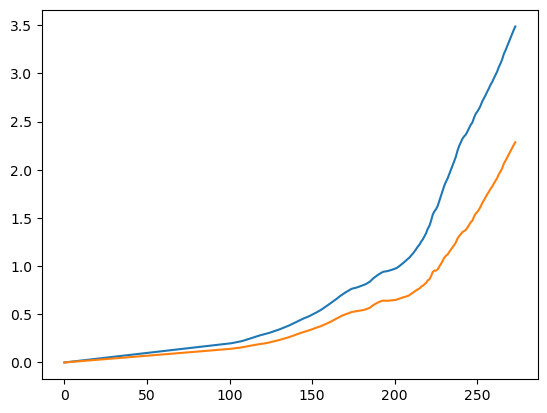

In [78]:
pl.plot(ghg_out.sum(axis=1))
pl.plot(forcing['CO2'])

### Ozone

Same as AR6 method: use ERF time series from Skeie et al. (2020) from 6 CMIP6 models, and fit coefficients for each precursor based on Thornhill et al. (2021)

In [79]:
# get temperature time series, needed to back out temperature feedback
temp_obs = pd.read_csv('../data/gmst/IGCC_GMST_1850-2022.csv', index_col=0).values
delta_gmst = [
    0,
    temp_obs[65:76].mean(),
    temp_obs[75:86].mean(),
    temp_obs[85:96].mean(),
    temp_obs[95:106].mean(),
    temp_obs[105:116].mean(),
    temp_obs[115:126].mean(),
    temp_obs[125:136].mean(),
    temp_obs[135:146].mean(),
    temp_obs[145:156].mean(),
    temp_obs[152:163].mean(),
    temp_obs[155:166].mean(),
    temp_obs[159:170].mean(),
    temp_obs[167].mean(),  # we don't use this
    temp_obs[168].mean(),
]  # this is the time periods used in Skeie et al.

In [80]:
# get the skeie data and back out the climate feedback (-0.037 W/m2/K)
good_models = [
    "BCC-ESM1",
    "CESM2(WACCM6)",
    "GFDL-ESM4",
    "GISS-E2-1-H",
    "MRI-ESM2-0",
    "OsloCTM3",
]

skeie_trop = pd.read_csv(
    "../data/ozone/skeie_ozone_trop.csv", index_col=0
)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method="values", limit_area="inside", inplace=True)

skeie_strat = pd.read_csv(
    "../data/ozone/skeie_ozone_strat.csv", index_col=0
)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method="values", limit_area="inside", inplace=True)

skeie_total = skeie_trop + skeie_strat

coupled_models = copy.deepcopy(good_models)
coupled_models.remove("OsloCTM3")

skeie_total.loc[coupled_models] = skeie_total.loc[coupled_models] - (-0.037) * np.array(
    delta_gmst
)
skeie_ssp245 = skeie_total.mean()
skeie_ssp245[1750] = -0.03
skeie_ssp245.sort_index(inplace=True)
skeie_ssp245 = skeie_ssp245 + 0.03
skeie_ssp245.drop([2014, 2017, 2020], inplace=True)
# skeie_ssp245 = skeie_ssp245.append(
#     skeie_total.loc["OsloCTM3", 2014:]
#     - skeie_total.loc["OsloCTM3", 2010]
#     + skeie_ssp245[2010]
# )
skeie_ssp245 = pd.concat(
    (
        skeie_ssp245,
        skeie_total.loc["OsloCTM3", 2014:] - skeie_total.loc["OsloCTM3", 2010] + skeie_ssp245[2010]
    )
)

f = interp1d(
    skeie_ssp245.index, skeie_ssp245, bounds_error=False, fill_value="extrapolate"
)
years = np.arange(1750, 2021)
o3total = f(years)

In [81]:
# Get 1750-2014 changes to compare with Thornhill CMIP6
# Thornhill uses 1850-2014. However, we want a 1750 baseline, and the coefficients will be scaled up anyway in order
# to match the Thornhill best estimate (0.31) to Skeie (0.47)
delta_Cch4 = concentrations.loc[2014, 'CH4'] - concentrations.loc[1750, 'CH4']
delta_Cn2o = concentrations.loc[2014, 'N2O'] - concentrations.loc[1750, 'N2O']
delta_Cods = total_eesc.loc[2014] - total_eesc.loc[1750]
delta_Eco = emissions.loc[2014, 'CO'] - emissions.loc[1750, 'CO']
delta_Enox = emissions.loc[2014, 'NOx'] - emissions.loc[1750, 'NOx']
delta_Evoc = emissions.loc[2014, 'NMVOC'] - emissions.loc[1750, 'NMVOC']

In [82]:
# create a timeseries of precursors as a new array
ts = np.vstack(
    (
        concentrations["CH4"],
        concentrations["N2O"],
        total_eesc,
        emissions["CO"],
        emissions["NMVOC"],
        emissions["NOx"],
    )
).T

In [83]:
# best estimate radiative efficienices from 2014 - 1850 from AR6 here from Thornhill. Used for scaling.
radeff_ch4 = 0.14 / delta_Cch4
radeff_n2o = 0.03 / delta_Cn2o
radeff_ods = -0.11 / delta_Cods  # excludes UKESM
radeff_co = 0.067 / delta_Eco  # stevenson CMIP5 scaled to CO + VOC total
radeff_voc = 0.043 / delta_Evoc  # stevenson CMIP5 scaled to CO + VOC total
radeff_nox = 0.20 / delta_Enox

In [84]:
# scale factor to convert from Skeie to Thornhill total ozone ERF
fac_cmip6_skeie = (
    radeff_ch4 * delta_Cch4
    + radeff_n2o * delta_Cn2o
    + radeff_ods * delta_Cods
    + radeff_co * delta_Eco
    + radeff_voc * delta_Evoc
    + radeff_nox * delta_Enox
) / (o3total[264] - o3total[0])
fac_cmip6_skeie

0.7390690935173068

In [85]:
# Fit timeseries of ozone forcing in the absence of climate feedbacks (calculated above)
# This is to compare the fixed-SST runs from Thornhill with the coupled runs from Skeie
# We back out the warming contribution from Skeie
# The bounds of the curve fit are a 90% range from model results in Thornhill et al. 2021, except for halocarbons where
# we exclude UKESM
# Thornhill coefficients are scaled (fac_cmip6_skeie) to preserve total ERF
def fit_precursors(x, rch4, rn2o, rods, rco, rvoc, rnox):
    return (
        rch4 * x[0] + rn2o * x[1] + rods * x[2] + rco * x[3] + rvoc * x[4] + rnox * x[5]
    )

p, cov = curve_fit(
    fit_precursors,
    ts[:270, :].T - ts[0:1, :].T,
    o3total[:270] - o3total[0],
    bounds=(  # 90% range from Thornhill for each precursor
        (
            0.09 / delta_Cch4 / fac_cmip6_skeie,
            0.01 / delta_Cn2o / fac_cmip6_skeie,
            -0.21 / delta_Cods / fac_cmip6_skeie,
            0.010 / delta_Eco / fac_cmip6_skeie,
            0 / delta_Evoc / fac_cmip6_skeie,
            0.09 / delta_Enox / fac_cmip6_skeie,
        ),
        (
            0.19 / delta_Cch4 / fac_cmip6_skeie,
            0.05 / delta_Cn2o / fac_cmip6_skeie,
            -0.01 / delta_Cods / fac_cmip6_skeie,
            0.124 / delta_Eco / fac_cmip6_skeie,
            0.086 / delta_Evoc / fac_cmip6_skeie,
            0.31 / delta_Enox / fac_cmip6_skeie,
        ),
    ),
)


In [86]:
forcing['O3'] = (
    p[0] * (concentrations["CH4"] - concentrations.loc[1750, "CH4"])
    + p[1] * (concentrations["N2O"] - concentrations.loc[1750, "N2O"])
    + p[2] * (total_eesc - total_eesc.loc[1750])
    + p[3] * (emissions["CO"] - emissions.loc[1750, "CO"])
    + p[4] * (emissions["NMVOC"] - emissions.loc[1750, "NMVOC"])
    + p[5] * (emissions["NOx"] - emissions.loc[1750, "NOx"])
).values.squeeze()

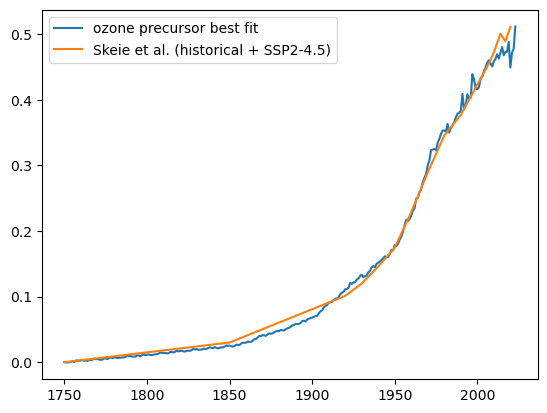

In [87]:
pl.plot(np.arange(1750, 2024), forcing['O3'], label='ozone precursor best fit')
pl.plot(np.arange(1750, 2021), o3total, label='Skeie et al. (historical + SSP2-4.5)')
pl.legend()

### Stratospheric water vapour

Simple scaling with methane forcing. Anchored to be 0.05 W/m2 in 2019.

In [88]:
sfh2ostrat = 0.05 / forcing['CH4'][269]
forcing['H2O_stratospheric'] = (forcing['CH4'] * sfh2ostrat)

## Aggregation

In [89]:
forcing

{'solar': array([ 9.75902620e-02,  7.92439729e-02,  4.91660432e-02,  1.29882845e-02,
        -2.14266081e-02, -4.59039275e-02, -5.34858122e-02, -3.43438933e-02,
         1.70132356e-02,  6.75123323e-02,  9.23952669e-02,  8.62486360e-02,
         6.41582063e-02,  3.08197542e-02, -5.93522629e-03, -3.57791472e-02,
        -4.98976775e-02, -3.67151823e-02,  1.94469270e-02,  8.55934114e-02,
         1.17262601e-01,  1.09711917e-01,  8.67790559e-02,  5.08353059e-02,
         1.00865755e-02, -2.56387663e-02, -4.67931609e-02, -4.29866179e-02,
         1.64665848e-03,  7.30505403e-02,  1.15827347e-01,  1.15671341e-01,
         9.13812288e-02,  5.45170442e-02,  1.09914095e-02, -2.57011687e-02,
        -4.49990935e-02, -3.13017790e-02,  3.73095979e-02,  1.17449808e-01,
         1.44626029e-01,  1.30523099e-01,  1.12348416e-01,  8.15684602e-02,
         4.57027132e-02,  7.80888992e-03, -2.60599821e-02, -5.10989226e-02,
        -6.33297820e-02, -6.08024870e-02, -4.25966032e-02, -1.27214812e-02,
   

In [90]:
pd.DataFrame(forcing, index=np.arange(1750, 2024)).to_csv('../output/ERF_best_1750-2023.csv')

In [91]:
for agent in tqdm(forcing):
    if agent not in ['aerosol-radiation_interactions', 'aerosol-cloud_interactions', 'solar']:
        forcing_ensemble[agent] = forcing[agent][:,None] * scale_df[agent].values[None,:]

  0%|          | 0/61 [00:00<?, ?it/s]

In [92]:
#forcing_ensemble

In [93]:
forcing_ensemble_sum = np.zeros((274, SAMPLES))
forcing_ensemble_anthro = np.zeros((274, SAMPLES))
forcing_ensemble_natural = np.zeros((274, SAMPLES))
forcing_ensemble_aerosol = np.zeros((274, SAMPLES))
forcing_ensemble_minorghg = np.zeros((274, SAMPLES))

for agent in tqdm(forcing):
    forcing_ensemble_sum = forcing_ensemble_sum + forcing_ensemble[agent]
    if agent in ['solar', 'volcanic']:
        forcing_ensemble_natural = forcing_ensemble_natural + forcing_ensemble[agent]
    else:
        forcing_ensemble_anthro = forcing_ensemble_anthro + forcing_ensemble[agent]
    if agent not in ['solar', 'volcanic', 'aerosol-radiation_interactions', 'aerosol-cloud_interactions',
                    'CO2', 'CH4', 'N2O', 'O3', 'H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use']:
        forcing_ensemble_minorghg = forcing_ensemble_minorghg + forcing_ensemble[agent]
    if agent in ['aerosol-radiation_interactions', 'aerosol-cloud_interactions']:
        forcing_ensemble_aerosol = forcing_ensemble_aerosol + forcing_ensemble[agent]

  0%|          | 0/61 [00:00<?, ?it/s]

In [94]:
forcing_sum = np.zeros((274))
forcing_anthro = np.zeros((274))
forcing_natural = np.zeros((274))
forcing_aerosol = np.zeros((274))
forcing_minorghg = np.zeros((274))

for agent in tqdm(forcing):
    forcing_sum = forcing_sum + forcing[agent]
    if agent in ['solar', 'volcanic']:
        forcing_natural = forcing_natural + forcing[agent]
    else:
        forcing_anthro = forcing_anthro + forcing[agent]
    if agent not in ['solar', 'volcanic', 'aerosol-radiation_interactions', 'aerosol-cloud_interactions',
                    'CO2', 'CH4', 'N2O', 'O3', 'H2O_stratospheric', 'contrails', 'BC_on_snow', 'land_use']:
        forcing_minorghg = forcing_minorghg + forcing[agent]
    if agent in ['aerosol-radiation_interactions', 'aerosol-cloud_interactions']:
        forcing_aerosol = forcing_aerosol + forcing[agent]

  0%|          | 0/61 [00:00<?, ?it/s]

In [95]:
forcing_p05 = {}
forcing_p95 = {}

for agent in tqdm(forcing):
    forcing_p05[agent] = np.percentile(forcing_ensemble[agent],5,axis=1)
    forcing_p95[agent] = np.percentile(forcing_ensemble[agent],95,axis=1)
    
forcing_p05_sum = np.percentile(forcing_ensemble_sum,5,axis=1)
forcing_p05_anthro = np.percentile(forcing_ensemble_anthro,5,axis=1)
forcing_p05_natural = np.percentile(forcing_ensemble_natural,5,axis=1)
forcing_p05_aerosol = np.percentile(forcing_ensemble_aerosol,5,axis=1)
forcing_p05_minorghg = np.percentile(forcing_ensemble_minorghg,5,axis=1)

forcing_p95_sum = np.percentile(forcing_ensemble_sum,95,axis=1)
forcing_p95_anthro = np.percentile(forcing_ensemble_anthro,95,axis=1)
forcing_p95_natural = np.percentile(forcing_ensemble_natural,95,axis=1)
forcing_p95_aerosol = np.percentile(forcing_ensemble_aerosol,95,axis=1)
forcing_p95_minorghg = np.percentile(forcing_ensemble_minorghg,95,axis=1)

  0%|          | 0/61 [00:00<?, ?it/s]

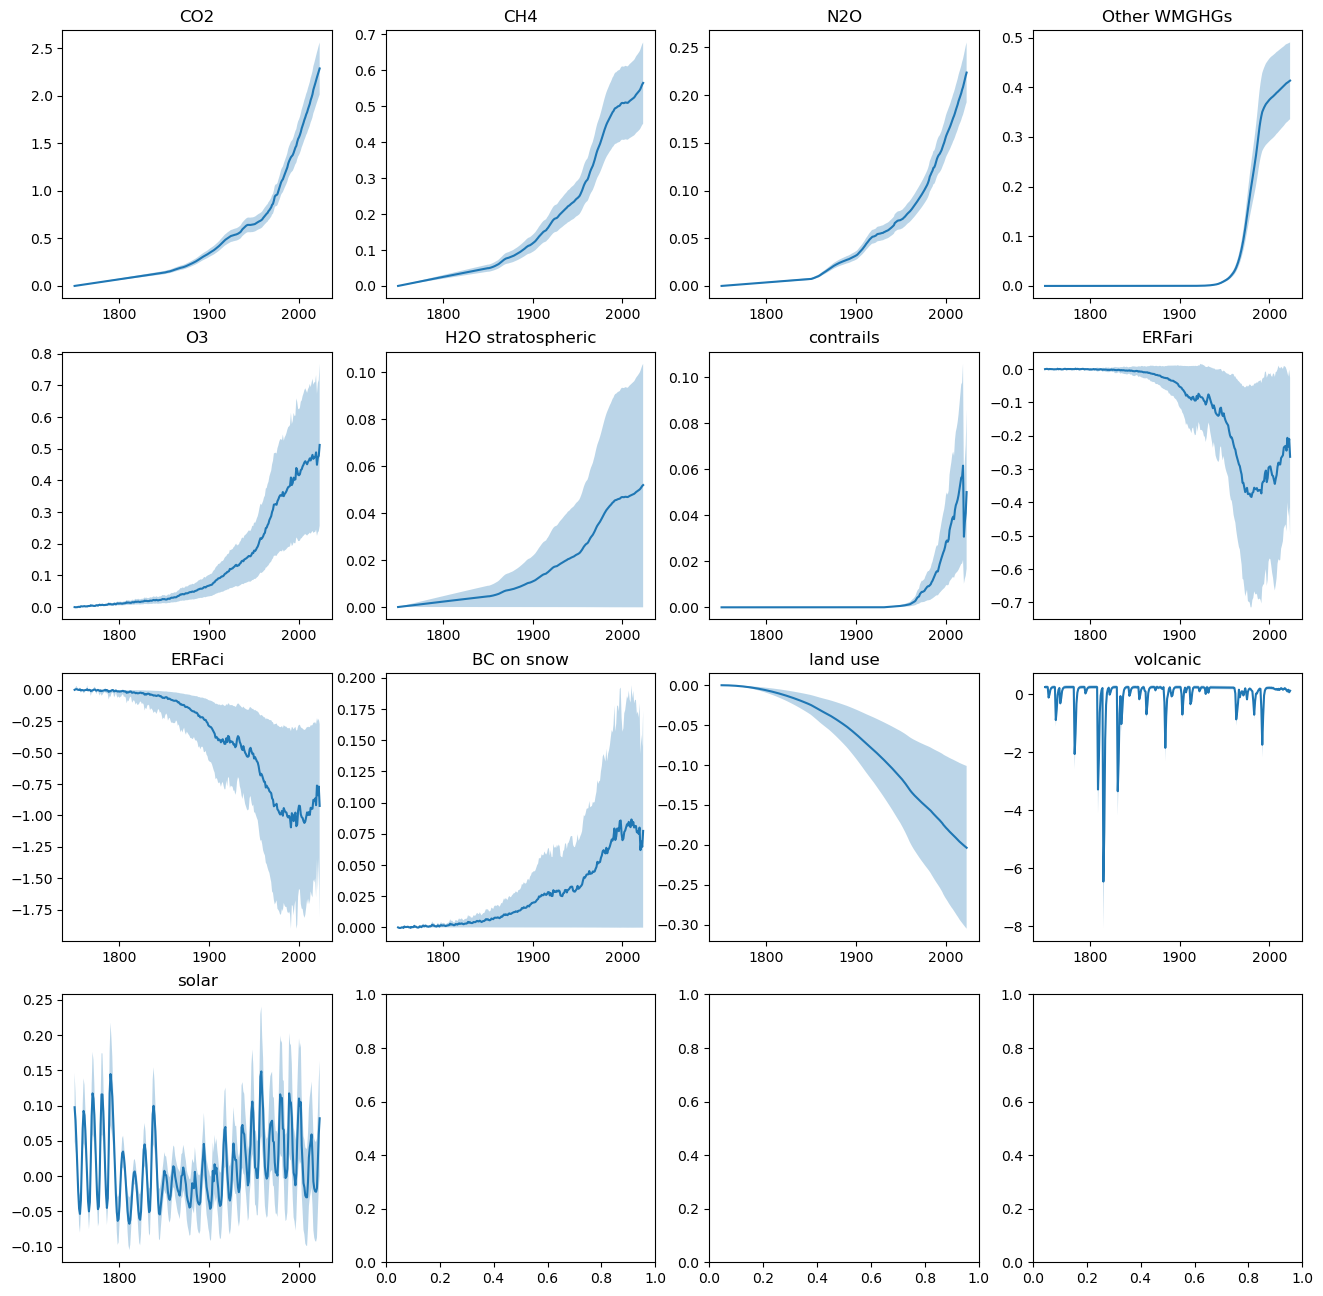

In [96]:
fig, ax = pl.subplots(4,4, figsize=(16,16),squeeze=True)
ax[0,0].fill_between(np.arange(1750,2024), forcing_p05['CO2'], forcing_p95['CO2'], alpha=0.3)
ax[0,0].plot(np.arange(1750,2024),forcing['CO2'])
ax[0,0].set_title('CO2')
ax[0,1].fill_between(np.arange(1750,2024), forcing_p05['CH4'], forcing_p95['CH4'], alpha=0.3)
ax[0,1].plot(np.arange(1750,2024),forcing['CH4'])
ax[0,1].set_title('CH4')
ax[0,2].fill_between(np.arange(1750,2024), forcing_p05['N2O'], forcing_p95['N2O'], alpha=0.3)
ax[0,2].plot(np.arange(1750,2024),forcing['N2O'])
ax[0,2].set_title('N2O')
ax[0,3].fill_between(np.arange(1750,2024), forcing_p05_minorghg, forcing_p95_minorghg, alpha=0.3)
ax[0,3].plot(np.arange(1750,2024),forcing_minorghg)
ax[0,3].set_title('Other WMGHGs')
ax[1,0].fill_between(np.arange(1750,2024), forcing_p05['O3'], forcing_p95['O3'], alpha=0.3)
ax[1,0].plot(np.arange(1750,2024),forcing['O3'])
ax[1,0].set_title('O3')
ax[1,1].fill_between(np.arange(1750,2024), forcing_p05['H2O_stratospheric'], forcing_p95['H2O_stratospheric'], alpha=0.3)
ax[1,1].plot(np.arange(1750,2024),forcing['H2O_stratospheric'])
ax[1,1].set_title('H2O stratospheric')
ax[1,2].fill_between(np.arange(1750,2024), forcing_p05['contrails'], forcing_p95['contrails'], alpha=0.3)
ax[1,2].plot(np.arange(1750,2024),forcing['contrails'])
ax[1,2].set_title('contrails')
ax[1,3].fill_between(np.arange(1750,2024), forcing_p05['aerosol-radiation_interactions'], forcing_p95['aerosol-radiation_interactions'], alpha=0.3)
ax[1,3].plot(np.arange(1750,2024),forcing['aerosol-radiation_interactions'])
ax[1,3].set_title('ERFari')
ax[2,0].fill_between(np.arange(1750,2024), forcing_p05['aerosol-cloud_interactions'], forcing_p95['aerosol-cloud_interactions'], alpha=0.3)
ax[2,0].plot(np.arange(1750,2024),forcing['aerosol-cloud_interactions'])
ax[2,0].set_title('ERFaci')
ax[2,1].fill_between(np.arange(1750,2024), forcing_p05['BC_on_snow'], forcing_p95['BC_on_snow'], alpha=0.3)
ax[2,1].plot(np.arange(1750,2024),forcing['BC_on_snow'])
ax[2,1].set_title('BC on snow')
ax[2,2].fill_between(np.arange(1750,2024), forcing_p05['land_use'], forcing_p95['land_use'], alpha=0.3)
ax[2,2].plot(np.arange(1750,2024),forcing['land_use'])
ax[2,2].set_title('land use')
ax[2,3].fill_between(np.arange(1750,2024), forcing_p05['volcanic'], forcing_p95['volcanic'], alpha=0.3)
ax[2,3].plot(np.arange(1750,2024),forcing['volcanic'])
ax[2,3].set_title('volcanic')
ax[3,0].fill_between(np.arange(1750,2024), forcing_p05['solar'], forcing_p95['solar'], alpha=0.3)
ax[3,0].plot(np.arange(1750,2024),forcing['solar'])
ax[3,0].set_title('solar');

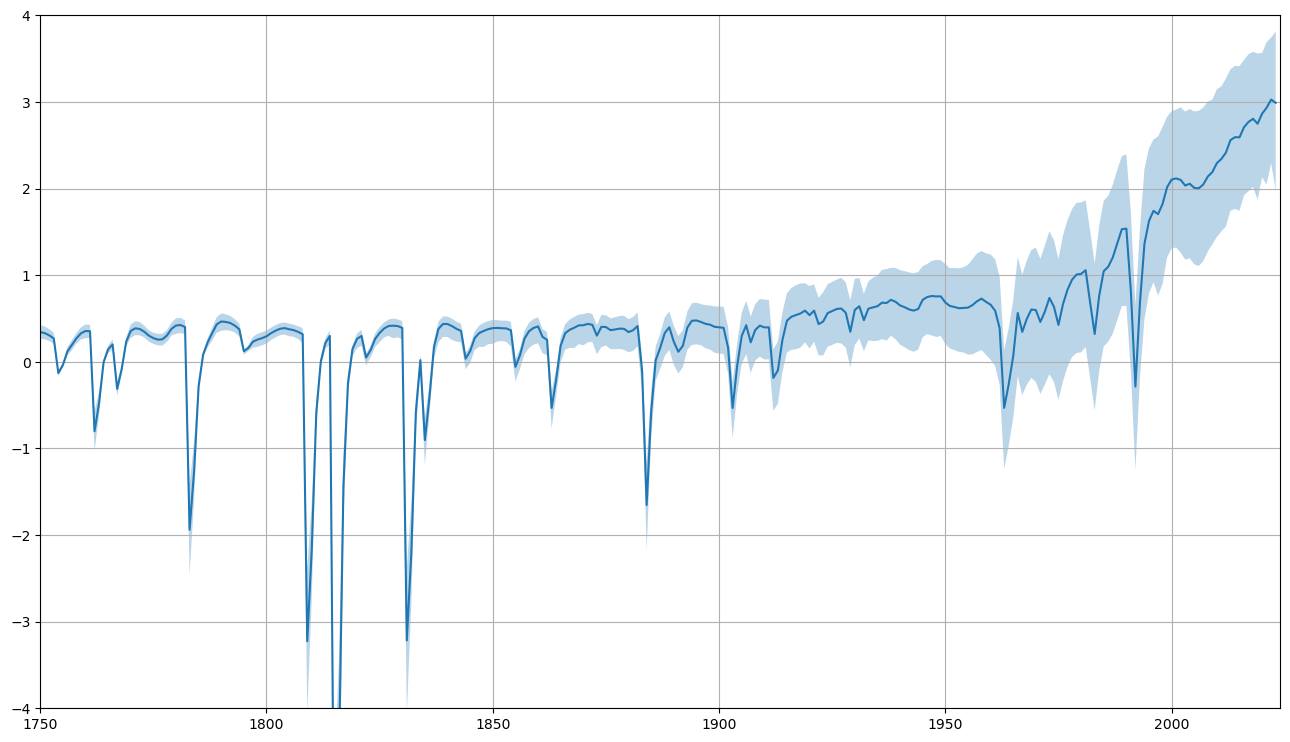

In [97]:
pl.figure(figsize=(16,9))
pl.fill_between(np.arange(1750,2024), forcing_p05_sum, forcing_p95_sum, alpha=0.3)
pl.plot(np.arange(1750,2024), forcing_sum)
pl.yticks(np.arange(-4,5))
pl.xticks(np.arange(1750,2020,50))
pl.ylim(-4,4)
pl.xlim(1750,2024)
pl.grid()

In [98]:
forcing_ensemble

{'solar': array([[ 0.08974845,  0.08822181,  0.13900456, ...,  0.10211565,
          0.11091376,  0.09364379],
        [ 0.07275333,  0.07160834,  0.11292047, ...,  0.08282473,
          0.09021183,  0.07603924],
        [ 0.04496925,  0.04438945,  0.0701262 , ...,  0.05125816,
          0.05617661,  0.04717747],
        ...,
        [-0.01511215,  0.01004507,  0.04071563, ..., -0.00479125,
          0.06233235,  0.0187205 ],
        [ 0.02152268,  0.04605673,  0.09745654, ...,  0.0368918 ,
          0.10760675,  0.05694539],
        [ 0.04229613,  0.06647682,  0.12963096, ...,  0.0605278 ,
          0.13327919,  0.07862047]]),
 'aerosol-radiation_interactions': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.68814843e-04,  1.09853242e-03,  9.88668410e-04, ...,
          4.81805429e-04, -5.52697574e-05,  4.50458500e-04],
        [-5.05484092e-04,  1.94221908e-03,  1.68000879e-03, ...,
          9.5

In [99]:
forcing_ensemble['CO2']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.33572243e-03, 1.53174611e-03, 1.43019302e-03, ...,
        1.36634293e-03, 1.44228277e-03, 1.51517485e-03],
       [2.67112676e-03, 3.06312743e-03, 2.86004544e-03, ...,
        2.73236046e-03, 2.88422206e-03, 3.02998885e-03],
       ...,
       [2.09701449e+00, 2.40476143e+00, 2.24532838e+00, ...,
        2.14508707e+00, 2.26430866e+00, 2.37874541e+00],
       [2.12760136e+00, 2.43983707e+00, 2.27807854e+00, ...,
        2.17637512e+00, 2.29733566e+00, 2.41344158e+00],
       [2.15534699e+00, 2.47165451e+00, 2.30778652e+00, ...,
        2.20475680e+00, 2.32729477e+00, 2.44491480e+00]])

In [100]:
for agent in forcing_ensemble:
    forcing_ensemble[agent] = xr.DataArray(
        forcing_ensemble[agent], 
        coords=dict(
            time=np.arange(1750, 2024),
            ensemble=np.arange(SAMPLES)
        )
    )

In [101]:
xr.Dataset(forcing_ensemble).to_netcdf('../output/ERF_ensemble.nc')